# Does $\theta$ set a decision threshold?

Several papers claim that $\theta$-band activity sets or modulates the threshold in drift diffusion models of decision making. Can we see this in our data?

In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import physutils
import dbio
import os
from __future__ import division
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

In [2]:
# which patient, dataset to plot
dtup = 18, 1

In [3]:
# set up relevant params
#bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']  # which bands to limit to
bands = ['theta']
Tpre = -5  # time before event to grab
Tpre_plot = -2  # time before event to plot
Tpost = 1.5  # time after event to grab
smwid = 0.2  # smoothing window (in s)

In [4]:
# load data
dbname = os.path.expanduser('data/bart.hdf5')
lfp = dbio.fetch_all_such_LFP(dbname, *dtup)

In [5]:
# bandpass filter
lfpraw = physutils.LFPset(lfp.copy(), meta=lfp.meta.copy())
if bands:
    lfp = lfp.bandlimit(bands)

In [6]:
# decimate to 100 Hz
lfp = lfp.decimate(5)
lfpraw = lfpraw.decimate(5)

In [7]:
# instantaneous power
lfp = lfp.instpwr()
lfpraw = lfpraw.instpwr()

In [8]:
# censor
lfp = lfp.censor()
lfpraw = lfpraw.censor()

In [9]:
# get events
evt = dbio.fetch(dbname, 'events', *dtup)
stops = evt['banked'].dropna()
pops = evt['popped'].dropna()
starts = evt['start inflating']
if 'is_control' in evt.columns:
    stops_free = evt.query('is_control == False')['banked'].dropna()
    stops_control = evt.query('is_control == True')['banked'].dropna()
    stops_rewarded = evt.query('trial_type != 4')['banked'].dropna()
    stops_unrewarded = evt.query('trial_type == 4')['banked'].dropna()
else:
    stops_free = stops
    stops_rewarded = stops

all_stops = pd.concat([stops, pops]).sort(inplace=False)
infl_times = all_stops - starts
infl_times.name = 'infl_time'

In [10]:
# make peri-stop frame
stop_split = lfp.evtsplit(stops_free, Tpre, Tpost)
stop_means = stop_split.groupby(level=1).median()
stop_df = physutils.LFPset(stop_means, meta=lfp.meta.copy()).zscore()
stop_df = stop_df.smooth(smwid)

# Plot the peri-stop power:

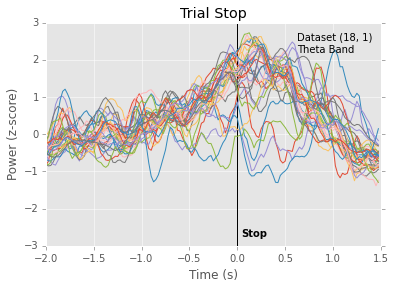

In [11]:
stop_df.plot(legend=False);

# decorations
plt.axvline(x=0, color='k', zorder=1)
plt.text(0.05, plt.ylim()[0] + 0.25, 'Stop', fontweight='bold')
plt.text(plt.xlim()[1] - 0.85, plt.ylim()[1] - 0.8, 
         "Dataset {}\n{} Band".format(str(dtup), bands[0].capitalize()))

plt.xlim(Tpre_plot, Tpost);
plt.title('Trial Stop')

plt.xlabel('Time (s)')
plt.ylabel('Power (z-score)');
plt.tick_params(axis='x', which='both', top='off');

# Trial stop trend:

                            OLS Regression Results                            
Dep. Variable:                  power   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     494.6
Date:                Mon, 15 Jun 2015   Prob (F-statistic):           9.42e-36
Time:                        14:08:56   Log-Likelihood:                 24.695
No. Observations:                  81   AIC:                            -45.39
Df Residuals:                      79   BIC:                            -40.60
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.1014      0.040     27.694      0.000         1.022     1.181
time           0.7636      0.034     22.240      0.0

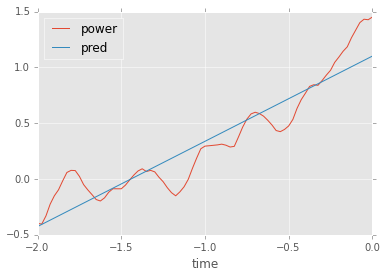

In [12]:
taxis = slice(-2, 0)
fit_data = stop_df.mean(axis=1)[taxis]
fit_data.name = 'power'
fit_data = fit_data.reset_index()
mod = smf.ols(formula='power ~ time', data=fit_data)
res = mod.fit()
print res.summary()
fit_data['pred'] = res.predict(fit_data)
fit_data.set_index('time').plot();

# How about variability across channels?

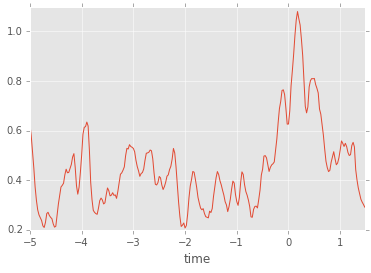

In [13]:
stop_df.std(axis=1).plot(legend=False);

## Let's look near trial start:

In [14]:
Tpre = -1
Tpost = 5
smwid = 0.2

In [15]:
def remove_post_inflate(df):
    # set all time points in a given trial after the stop/pop to NaN
    which_trial = df.index[0][0]
    new_df = df.copy()
    new_df.loc[which_trial].loc[slice(infl_times[which_trial], Tpost)] = np.nan
    return new_df

In [16]:
# make a dataframe of starts
start_split = lfp.evtsplit(starts, Tpre, Tpost)

# remove post-inflate data from each trial
start_split = start_split.groupby(level=0).apply(remove_post_inflate)

start_means = start_split.groupby(level=1).median()
start_df = physutils.LFPset(start_means, meta=lfp.meta.copy()).zscore()
start_df = start_df.smooth(smwid)

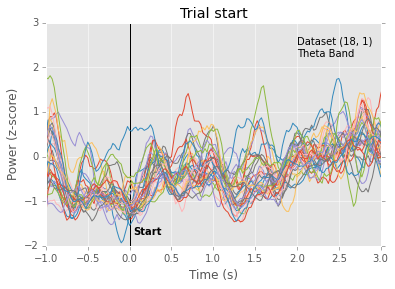

In [17]:
start_df.plot(legend=False);
plt.xlim(-1, 3);

# decorations
plt.axvline(x=0, color='k', zorder=1)
plt.text(0.05, plt.ylim()[0] + 0.25, 'Start', fontweight='bold');
plt.text(plt.xlim()[1] - 1, plt.ylim()[1] - 0.75, 
         "Dataset {}\n{} Band".format(str(dtup), bands[0].capitalize()))

plt.xlabel('Time (s)')
plt.ylabel('Power (z-score)');
plt.title('Trial start');

plt.tick_params(axis='x', which='both', top='off');

# Trial start trend

                            OLS Regression Results                            
Dep. Variable:                  power   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     669.1
Date:                Mon, 15 Jun 2015   Prob (F-statistic):           2.03e-65
Time:                        14:08:59   Log-Likelihood:                -30.042
No. Observations:                 200   AIC:                             64.08
Df Residuals:                     198   BIC:                             70.68
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.7634      0.040    -19.172      0.000        -0.842    -0.685
time           0.3581      0.014     25.867      0.0

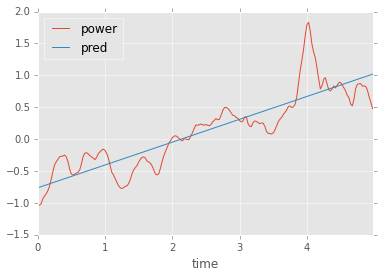

In [18]:
taxis = slice(0, None)
fit_data = start_df.mean(axis=1)[taxis]
fit_data.name = 'power'
fit_data = fit_data.reset_index()
mod = smf.ols(formula='power ~ time', data=fit_data)
res = mod.fit()
print res.summary()
fit_data['pred'] = res.predict(fit_data)
fit_data.set_index('time').plot();

## How does initial $\theta$ power correlate with inflate time?

In [19]:
# take mean across channels for each trial and grab power at smwid 
# (really average power from 0 to smwid due to smoothing)
initial_pwr = start_split.mean(axis=1).loc[:, 0:2].groupby(level=0).sum()
final_pwr = stop_split.mean(axis=1).loc[:, -2:0].groupby(level=0).sum()

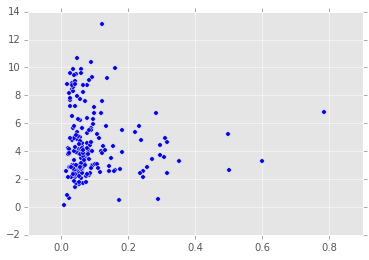

In [20]:
plt.scatter(initial_pwr, infl_times);

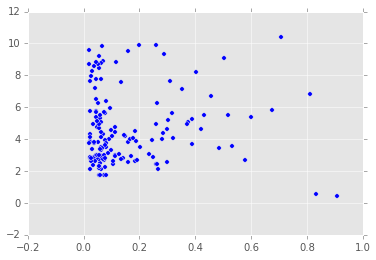

In [21]:
plt.scatter(final_pwr, infl_times[stops_free.index]);

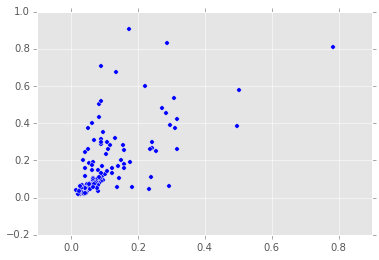

In [22]:
plt.scatter(initial_pwr[stops_free.index], final_pwr);

## What about a median split of successful stops?

In [23]:
# get times of successful stops
success_times = infl_times[stops.index]

In [24]:
# do a median split on these times
lo_trials = success_times[success_times < success_times.median()].index
hi_trials = success_times[success_times > success_times.median()].index

In [25]:
# split data frames peri-start and peri-stop
start_split_lo = start_split.loc[(lo_trials, slice(None)), :]
start_split_hi = start_split.loc[(hi_trials, slice(None)), :]
stop_split_lo = stop_split.loc[(lo_trials, slice(None)), :]
stop_split_hi = stop_split.loc[(hi_trials, slice(None)), :]

In [26]:
# use all data to set normalization parameters
start_mu = start_means.mean()
start_sig = start_means.std()
stop_mu = stop_means.mean()
stop_sig = stop_means.std()

In [27]:
start_lo_mean = (start_split_lo.groupby(level=1).median() - start_mu) / start_sig
start_hi_mean = (start_split_hi.groupby(level=1).median() - start_mu) / start_sig
stop_lo_mean = (stop_split_lo.groupby(level=1).median() - stop_mu) / stop_sig
stop_hi_mean = (stop_split_hi.groupby(level=1).median() - stop_mu) / stop_sig

In [28]:
start_lo_df = physutils.LFPset(start_lo_mean, meta=lfp.meta.copy()).smooth(smwid)
start_hi_df = physutils.LFPset(start_hi_mean, meta=lfp.meta.copy()).smooth(smwid)
stop_lo_df = physutils.LFPset(stop_lo_mean, meta=lfp.meta.copy()).smooth(smwid)
stop_hi_df = physutils.LFPset(stop_hi_mean, meta=lfp.meta.copy()).smooth(smwid)

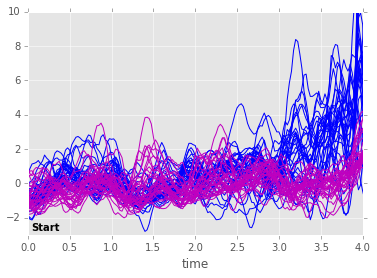

In [29]:
ax = start_lo_df.plot(legend=False, color='b');
start_hi_df.plot(legend=False, color='m', ax=ax);
plt.xlim(0, 4);
plt.ylim(-3, 10);

# decorations
plt.text(0.05, plt.ylim()[0] + 0.25, 'Start', fontweight='bold');

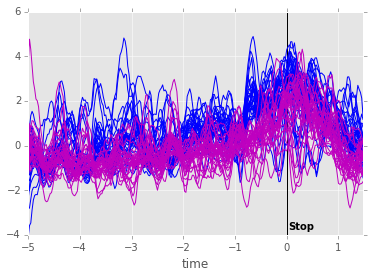

In [30]:
ax = stop_lo_df.plot(legend=False, color='b');
stop_hi_df.plot(legend=False, color='m', ax=ax);
plt.ylim(-4, 6);
# decorations
plt.axvline(x=0, color='k', zorder=1)
plt.text(0.05, plt.ylim()[0] + 0.25, 'Stop', fontweight='bold');

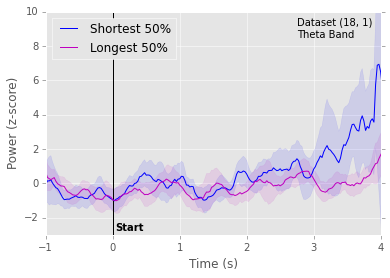

In [31]:
lo_med = start_lo_df.median(axis=1)
hi_med = start_hi_df.median(axis=1)
ax = lo_med.plot(color='b')
hi_med.plot(color='m', ax=ax);

# error bars: use median absolute deviation to get robust std 
sigfac = 1.4826  # = \Phi^{-1}(3/4)
rstd_lo = start_lo_df.abs().std(axis=1) * sigfac
rstd_hi = start_hi_df.abs().std(axis=1) * sigfac

# plot shading around lines
plt.fill_between(lo_med.index, lo_med - rstd_lo, lo_med + rstd_lo, color='b', alpha=0.1)
plt.fill_between(hi_med.index, hi_med - rstd_hi, hi_med + rstd_hi, color='m', alpha=0.1)

# axis limits
plt.xlim(-1, 4);
plt.ylim(-3, 10)

# axis labels
plt.xlabel('Time (s)')
plt.ylabel('Power (z-score)')

# decorations
plt.axvline(x=0, color='k', zorder=1)
plt.text(0.05, plt.ylim()[0] + 0.25, 'Start', fontweight='bold');
plt.tick_params(axis='x', which='both', top='off');
plt.text(plt.xlim()[1] - 1.25, plt.ylim()[1] - 1.5, 
         "Dataset {}\n{} Band".format(str(dtup), bands[0].capitalize()))

# legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Shortest 50%', 'Longest 50%'], loc='upper left');

Note that in the graph above, uncertainty in the estimate increases with time, as there are fewer trials with inflation durations that long.

# Does rate of power change covary with trial duration?

Assemble the data

In [32]:
# take peri-event dataframe, zscore within channel
start_trial_by_trial = physutils.LFPset(start_split).zscore()

# take mean across channels
start_trial_by_trial = start_trial_by_trial.mean(axis=1)

# swap around index into column
start_trial_by_trial.name = 'power'
start_trial_by_trial = start_trial_by_trial.reset_index(level=1)

# standardize inflate times and join to dataframe
zinf = (infl_times - infl_times.mean()) / infl_times.std()
start_trial_by_trial = start_trial_by_trial.join(zinf)

start_trial_by_trial.head()

,time,power,infl_time
trial,,,
0,-1.000,3.342925,-1.667337
0,-0.975,3.902700,-1.667337
0,-0.950,3.193664,-1.667337
0,-0.925,1.592003,-1.667337
0,-0.900,0.580225,-1.667337


Fit the model:

                            OLS Regression Results                            
Dep. Variable:                  power   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     159.8
Date:                Mon, 15 Jun 2015   Prob (F-statistic):          1.17e-102
Time:                        14:09:01   Log-Likelihood:                -22212.
No. Observations:               26826   AIC:                         4.443e+04
Df Residuals:                   26822   BIC:                         4.447e+04
Df Model:                           3                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept         -0.0712      0.007    -10.908      0.000        -0.084    -0.058
infl_time         -0.0233      0.007    

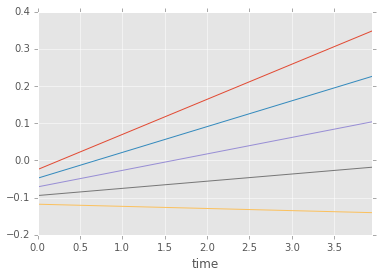

In [33]:
taxis = (0, 4)
fit_data = start_trial_by_trial.query('time >= @taxis[0] & time <= @taxis[1]')
mod = smf.ols(formula='power ~ infl_time * time', data=fit_data)
res = mod.fit()
print res.summary()

# make data frame of predictions
tdf = pd.DataFrame({'time': np.arange(*taxis, step=0.05), 'key': 1})
infl_df = pd.DataFrame({'infl_time': [-2, -1, 0, 1, 2], 'key': 1})
pred_df = pd.merge(tdf, infl_df, how='outer').drop('key', axis=1)
pred_df['power'] = res.predict(pred_df)

# munge into shape for plotting
plot_df = pred_df.set_index(['infl_time', 'time']).unstack(level=0)

plot_df.plot(legend=False);

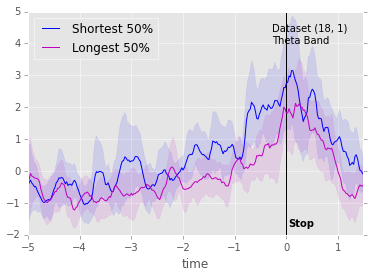

In [34]:
lo_med = stop_lo_df.median(axis=1)
hi_med = stop_hi_df.median(axis=1)
ax = lo_med.plot(color='b')
hi_med.plot(color='m', ax=ax);

# error bars: use median absolute deviation to get robust std 
sigfac = 1.4826  # = \Phi^{-1}(3/4)
rstd_lo = stop_lo_df.abs().std(axis=1) * sigfac
rstd_hi = stop_hi_df.abs().std(axis=1) * sigfac

# plot shading around lines
plt.fill_between(lo_med.index, lo_med - rstd_lo, lo_med + rstd_lo, color='b', alpha=0.1)
plt.fill_between(hi_med.index, hi_med - rstd_hi, hi_med + rstd_hi, color='m', alpha=0.1)

# decorations
plt.axvline(x=0, color='k', zorder=1)
plt.text(0.05, plt.ylim()[0] + 0.25, 'Stop', fontweight='bold');
plt.tick_params(axis='x', which='both', top='off');
plt.text(plt.xlim()[1] - 1.75, plt.ylim()[1] - 1, 
         "Dataset {}\n{} Band".format(str(dtup), bands[0].capitalize()))

# legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Shortest 50%', 'Longest 50%'], loc='upper left');

# Fit stop model:

In [35]:
# take peri-event dataframe, zscore within channel
stop_trial_by_trial = physutils.LFPset(stop_split).zscore()

# take mean across channels
stop_trial_by_trial = stop_trial_by_trial.mean(axis=1)

# swap around index into column
stop_trial_by_trial.name = 'power'
stop_trial_by_trial = stop_trial_by_trial.reset_index(level=1)

# standardize inflate times and join to dataframe
zinf = (infl_times - infl_times.mean()) / infl_times.std()
stop_trial_by_trial = stop_trial_by_trial.join(zinf)

stop_trial_by_trial.head()

,time,power,infl_time
trial,,,
0,-5.000,0.708582,-1.667337
0,-4.975,0.788780,-1.667337
0,-4.950,0.799378,-1.667337
0,-4.925,0.856546,-1.667337
0,-4.900,1.006215,-1.667337


                            OLS Regression Results                            
Dep. Variable:                  power   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     66.82
Date:                Mon, 15 Jun 2015   Prob (F-statistic):           5.05e-43
Time:                        14:09:01   Log-Likelihood:                -30119.
No. Observations:               24472   AIC:                         6.025e+04
Df Residuals:                   24468   BIC:                         6.028e+04
Df Model:                           3                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept          0.1236      0.011     11.723      0.000         0.103     0.144
infl_time         -0.0246      0.011    

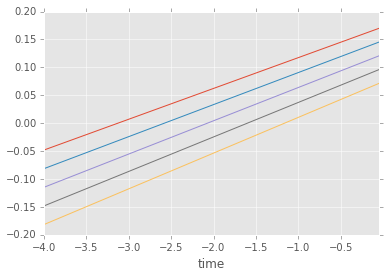

In [36]:
taxis = (-4, 0)
fit_data = stop_trial_by_trial.query('time >= @taxis[0] & time <= @taxis[1]')
mod = smf.ols(formula='power ~ infl_time * time', data=fit_data)
res = mod.fit()
print res.summary()

# make data frame of predictions
tdf = pd.DataFrame({'time': np.arange(*taxis, step=0.05), 'key': 1})
infl_df = pd.DataFrame({'infl_time': [-2, -1, 0, 1, 2], 'key': 1})
pred_df = pd.merge(tdf, infl_df, how='outer').drop('key', axis=1)
pred_df['power'] = res.predict(pred_df)

# munge into shape for plotting
plot_df = pred_df.set_index(['infl_time', 'time']).unstack(level=0)

plot_df.plot(legend=False);

## Look at variability across channels

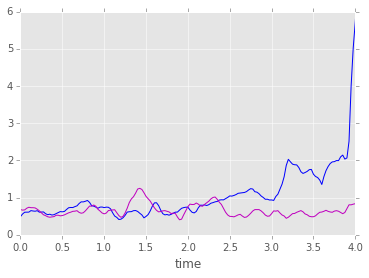

In [37]:
ax = start_lo_df.std(axis=1).plot(color='b');
start_hi_df.std(axis=1).plot(color='m', ax=ax);
plt.xlim(0, 4);
plt.ylim(0, 6);

Note that in the graph above, the increase in variance near the end is due to the fact that we are removing sections of the trials that did not last long. That is, the effective sample size decreases as time increases.

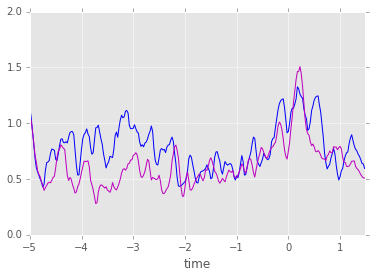

In [38]:
ax = stop_lo_df.std(axis=1).plot(color='b');
stop_hi_df.std(axis=1).plot(color='m', ax=ax);
plt.ylim(0, 2);